# Rotated MNIST - Exploratory Data Analysis (EDA)

This notebook performs the following steps:
- Loads the MNIST dataset.
- Applies random rotations to create a rotated version of MNIST.
- Visualizes original and rotated images.
- Performs exploratory data analysis.
- Filters the dataset removing blurry/faint digits.
- Explores embedding space through dimensionality reduction.

In [15]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torchvision.transforms.functional as TF
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import os
import warnings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [16]:
# Basic MNIST transformation
base_transform = transforms.ToTensor()
data_path = os.path.join('.', 'data')
mnist = MNIST(root=data_path, train=True, download=True, transform=base_transform)

In [17]:
# Rotation transform
rotation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-180, 180))
])

# Apply rotation to a set/subset
rotated_data = [(rotation_transform(img), label) for img, label in list(mnist)]#random.sample(list(mnist), 1000)]

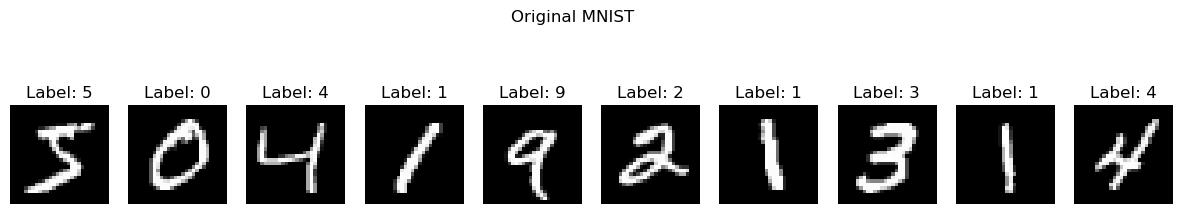

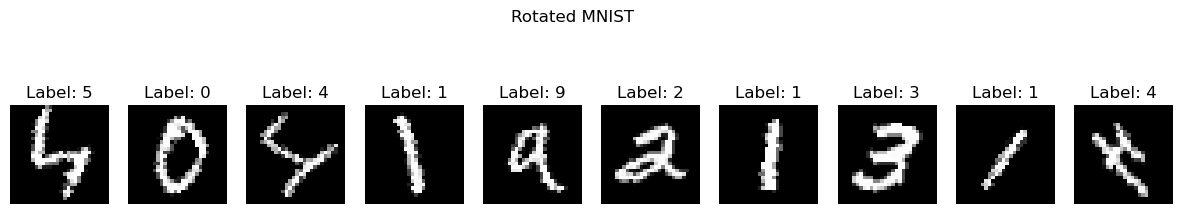

In [18]:
# Visualization
def show_images(dataset, title, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    fig.suptitle(title)
    for i in range(n):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

show_images(list(mnist), "Original MNIST")
show_images(rotated_data, "Rotated MNIST")

🗂 Total samples in dataset: 60000
🖼 Image shape: torch.Size([1, 28, 28])
🔢 Class distribution:
  Digit 0: 5923 samples
  Digit 1: 6742 samples
  Digit 2: 5958 samples
  Digit 3: 6131 samples
  Digit 4: 5842 samples
  Digit 5: 5421 samples
  Digit 6: 5918 samples
  Digit 7: 6265 samples
  Digit 8: 5851 samples
  Digit 9: 5949 samples


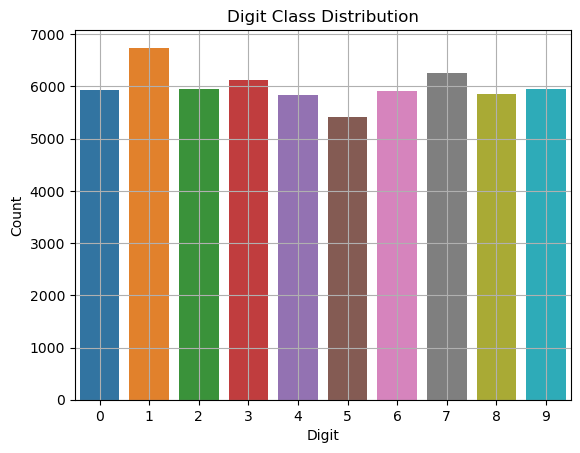

🧪 Total NaNs found in image tensors: 0
✅ Cleaned dataset size: 60000 samples (from 60000)


In [19]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Get data and labels as lists
images = [img for img, label in mnist]
labels = [label for _, label in mnist]

# 1. Dataset size
print(f"🗂 Total samples in dataset: {len(mnist)}")

# 2. Image shape
print(f"🖼 Image shape: {images[0].shape}")

# 3. Check class balance
label_counts = Counter(labels)
print("🔢 Class distribution:")
for label, count in sorted(label_counts.items()):
    print(f"  Digit {label}: {count} samples")

# Plot class distribution
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Digit Class Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 4. Check for NaNs (just in case, rare in torchvision)

def count_nans(tensor_dataset):
    total_nans = 0
    for img, _ in tensor_dataset:
        total_nans += torch.isnan(img).sum().item()
    return total_nans

nan_count = count_nans(mnist)
print(f"🧪 Total NaNs found in image tensors: {nan_count}")

# Function to check and remove NaNs or corrupted images
def clean_dataset(dataset):
    cleaned_data = []
    for img, label in dataset:
        if not torch.isnan(img).any():
            cleaned_data.append((img, label))
    return cleaned_data

# Clean the dataset
cleaned_mnist = clean_dataset(mnist)
print(f"✅ Cleaned dataset size: {len(cleaned_mnist)} samples (from {len(mnist)})")


Analyzing quality: 100%|██████████| 60000/60000 [00:15<00:00, 3770.74it/s]


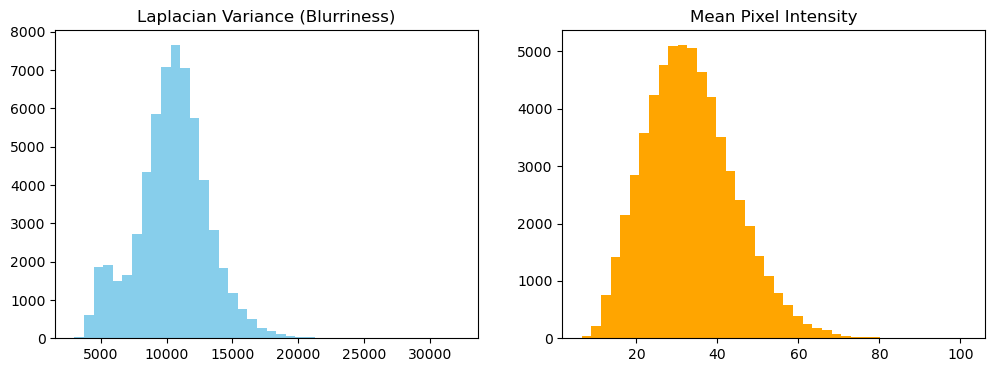

🧼 Filtered dataset size (after removing blurry/faint): 42578 samples


In [20]:
def quality_score(img_tensor):
    img = TF.to_pil_image(img_tensor)
    img_np = np.array(img)
    lap_var = cv2.Laplacian(img_np, cv2.CV_64F).var()  # Blurriness
    intensity = img_np.mean()  # Brightness
    return lap_var, intensity

# Analyze image quality
laplacians = []
intensities = []
for img, _ in tqdm(cleaned_mnist, desc="Analyzing quality"):
    lap, inten = quality_score(img)
    laplacians.append(lap)
    intensities.append(inten)

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(laplacians, bins=40, color='skyblue')
axes[0].set_title("Laplacian Variance (Blurriness)")
axes[1].hist(intensities, bins=40, color='orange')
axes[1].set_title("Mean Pixel Intensity")
plt.show()

# Thresholds (you can tune these yourself)
lap_thresh = np.percentile(laplacians, 20)   # bottom % blurriest
intensity_thresh = np.percentile(intensities, 20)  # faintest %

# Filter
filtered_data = [
    (img, label)
    for (img, label), lap, inten in zip(cleaned_mnist, laplacians, intensities)
    if lap > lap_thresh and inten > intensity_thresh
]

print(f"🧼 Filtered dataset size (after removing blurry/faint): {len(filtered_data)} samples")


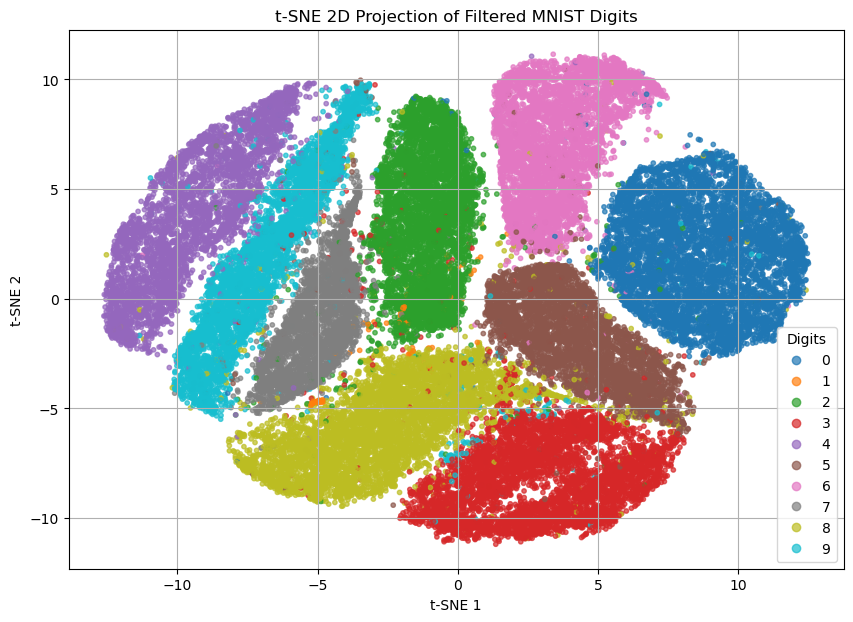

In [23]:
# Unpack filtered data
images, labels = zip(*filtered_data)

# Flatten images to vectors (required for PCA/t-SNE)
X = np.array([img.numpy().flatten() for img in images])  # convert from torch.Tensor to numpy array

# Reduce dimensionality with PCA before t-SNE (optional but recommended)
pca_50 = PCA(n_components=100)
X_pca_50 = pca_50.fit_transform(X)

# Apply t-SNE (this can be slow on large datasets!)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_pca_50)

# Plot t-SNE result
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digits", loc="best")
plt.title("t-SNE 2D Projection of Filtered MNIST Digits")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

